### MTheory feature-engineering demo

In [2]:
import MTheory as mt

In [3]:
import numpy as np
import pandas as pd
import collections
import os

In [4]:
import librosa
import librosa.display

In [5]:
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import seaborn as sns

Audio mining instructions:

In [6]:
main_path = '/Users/ilanmoscovitz/github/sf18_ds11/projects/03-mcnulty/Music/'

music_universe = {'Bach': ['Art_of_Fugue','Goldberg_Variations','Partitas','Sinfonia','Two_Part_Inventions','WTC1','WTC2','Other'],
                  'Mozart': ['Sonatas','Sonatinas','Fugue','Variations','Other']}

df_filename = '/Users/ilanmoscovitz/github/sf18_ds11/projects/03-mcnulty/Raw_Arrays.pkl'
extraction_keys = ['y','sr','y_harmonic','y_percussive','chroma', 'sparse']
examples_path = main_path + 'Samples/'

In [7]:
def add_example(df, sample):
    
    # Collect extractions
    y = sample.base['y']
    sr = sample.base['sr']
    chroma = sample.base['chroma']

    # Idee
    idee = {'Composer':sample.idee['Composer'],
            'Collection':sample.idee['Collection'],
            'Song':sample.idee['Song'],
            'Snippet':sample.idee['Snippet']}
    
    # Process features
    
    poly_mean, poly_var = get_polyphony(chroma, tempo)
    
    # Add features to df
    features = {'Tempo':tempo,
                'SCentr_Range':sc_range,
                'Poly_mean':poly_mean,
                'Poly_var':poly_var} 

    for band in range(len(contrast_mean)):
        features['SContr_mean'+str(band)] = contrast_mean[band]
    for band in range(len(contrast_var)):
        features['SContr_var'+str(band)] = contrast_var[band]
                
    to_add = idee.copy()
    to_add.update(features)
    df = df.append(to_add, ignore_index=True)
    return df

In [8]:
def cols_to_front(df, front_cols):
    cols = list(df)
    for col in reversed(front_cols):
        cols.insert(0, cols.pop(cols.index(col)))
    return df[cols]

In [9]:
def make_df(examples_path):
    df = pd.DataFrame()
    sample_filenames = os.listdir(examples_path)
    
    count = 1
    for sample_filename in sample_filenames:
        if 'example' in sample_filename: 
            sample = mt.get_pickle(examples_path+sample_filename)
            df = add_example(df, sample)
        if not count%10: 
            print('Example', count, 'of', len(sample_filenames))
        count+=1
        
    front_cols = ['Composer', 'Collection', 'Song', 'Snippet', 'Tempo']
    df = cols_to_front(df, front_cols)
    
    return df

In [10]:
# Load up a Sample from a song I chose at random.
# It's from the the beginning of Mozart's F-Major piano sonata K332.

sample = mt.get_pickle(examples_path+'example_997.pkl')
sample.idee

{'Collection': 'Sonatas',
 'Composer': 'Mozart',
 'Snippet': (1, 19),
 'Song': 'mz_332_1'}

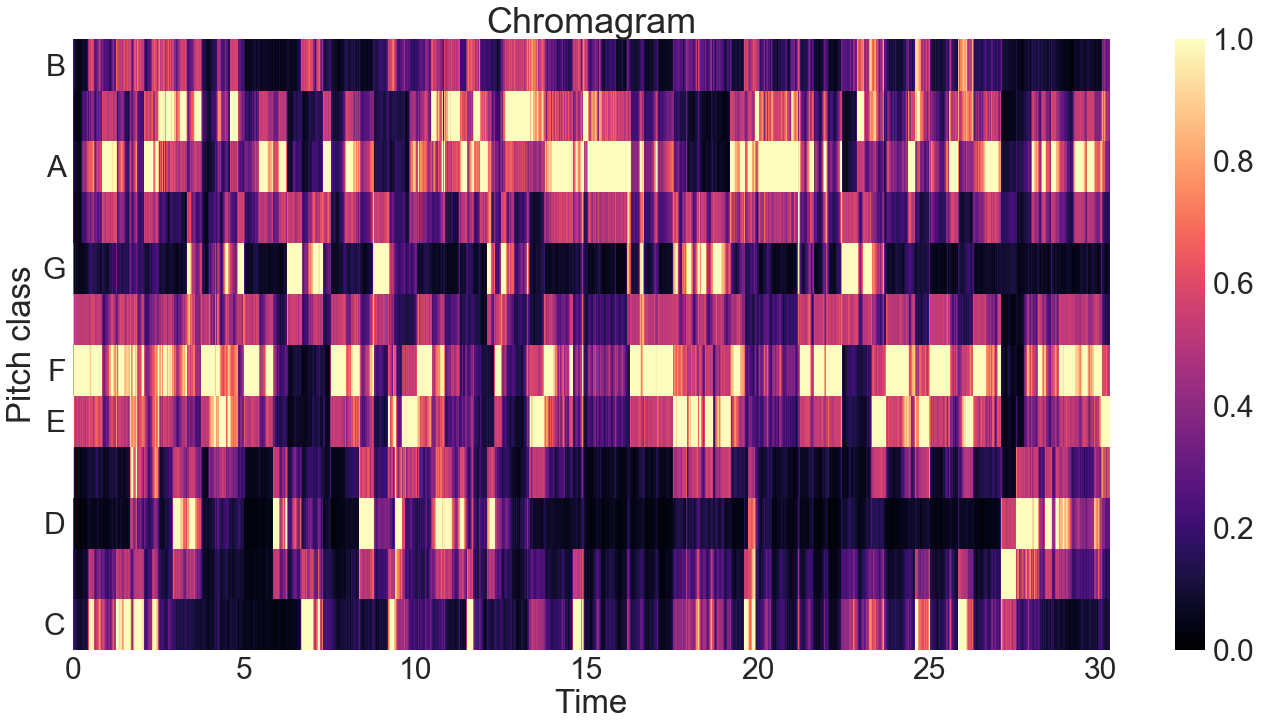

In [11]:
# Visualize chromogram of pitch classes
mt.display_chroma(sample.base['chroma']);

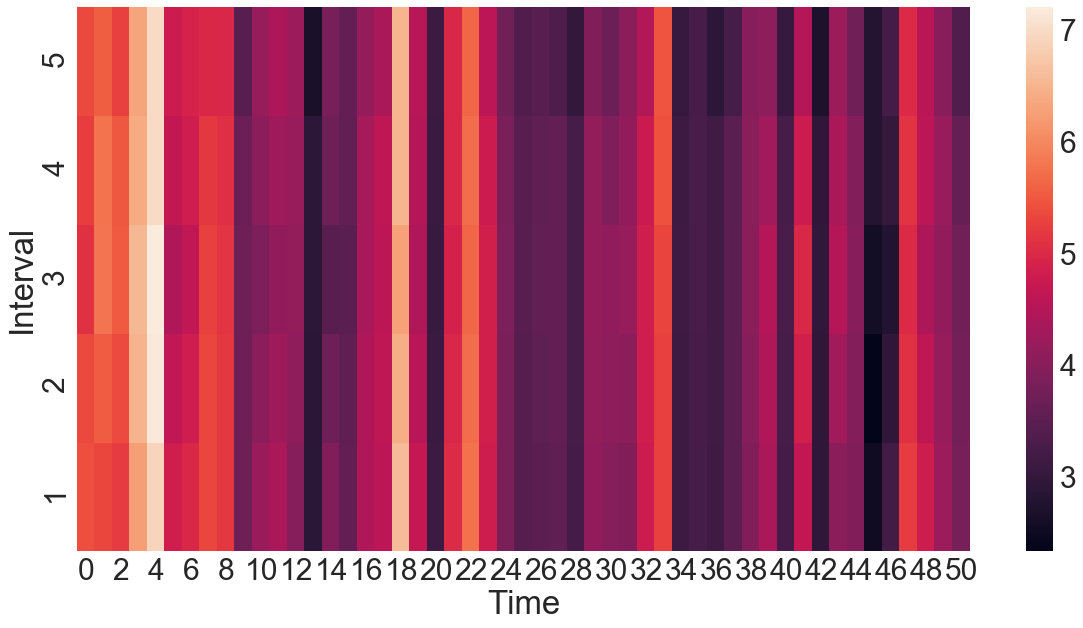

In [12]:
# We can extract interval density
# Note: Tritone (6) omitted from graph here b/c it's so uncommon to classical music,
# but it's still captured in the features.

sample.display_intervals(bins=50)

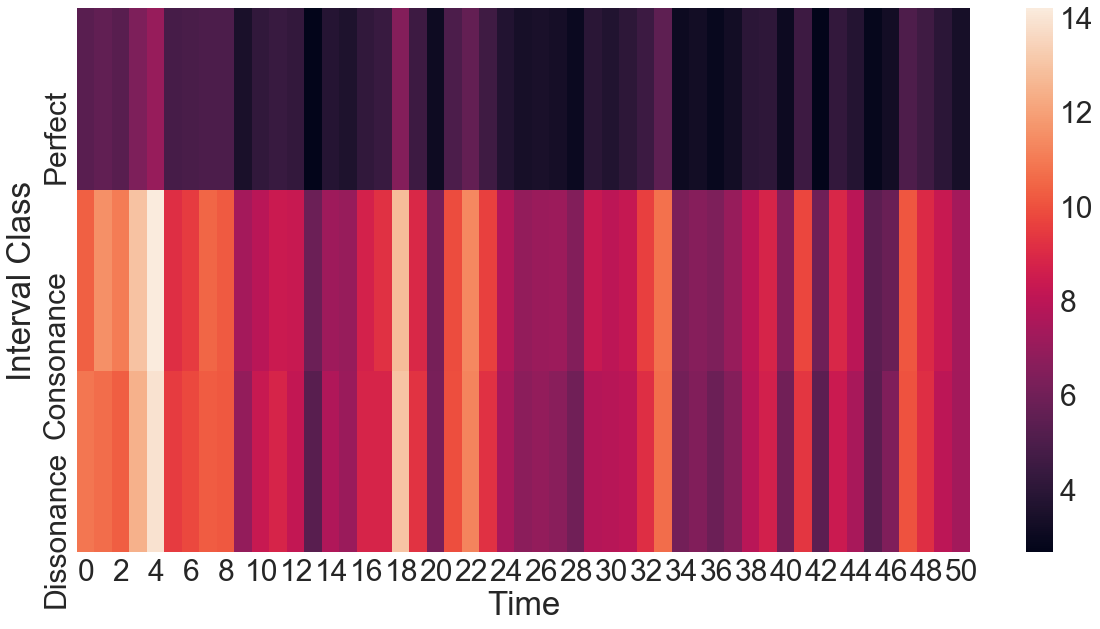

In [13]:
# And measure the level of dissonance or consonance.

sample.display_interval_classes(bins=50)

In [14]:
# We can look at the level of polyphony

sample.polyphony_array()

array([0.04264882, 0.08892584, 0.08816201, ..., 0.06750721, 0.06384022,
       0.06436827])

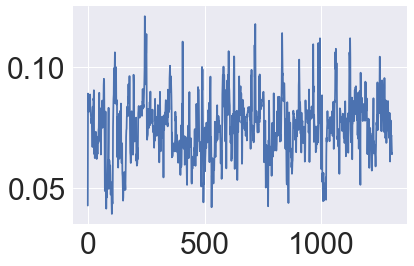

In [15]:
# Polyphony:

plt.plot(sample.polyphony_array());

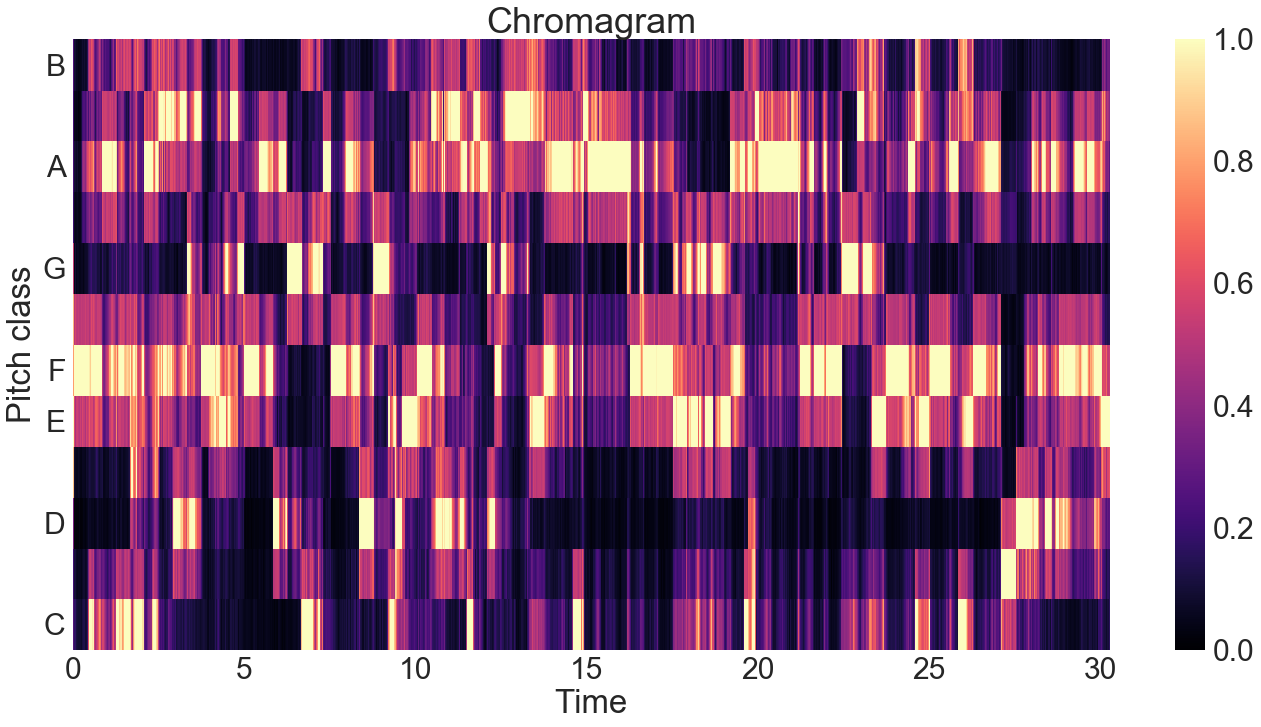

In [16]:
# Let's go back to the chromagram:

mt.display_chroma(sample.base['chroma']);

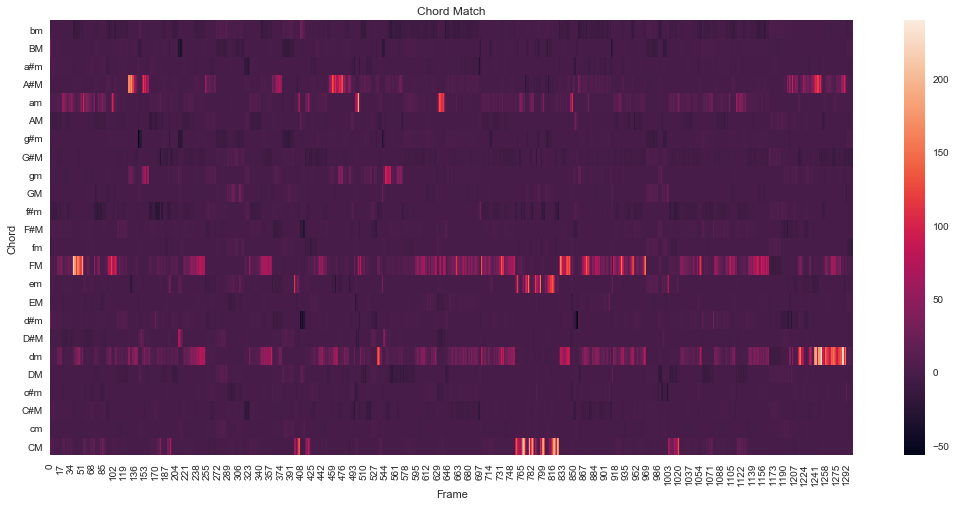

In [17]:
# MTheory can clarify the harmonic structure by extracting chord features that best fit the underlying notes.

sample.display_chords(exaggerate=5)

In [19]:
# We can now see the song begins with FM chords, 
# but there's also a fair bit of A- and C-chords.
# The key of FM is the best fit:

sample.build_tonality_matches()
sample.tonality

FM

In [20]:
# Here is the tonality distribution:

sample.tonalities(sort=True)

OrderedDict([(FM, 7.6303949783391065),
             (A#M, 5.303629163394653),
             (dm, 5.113732405273449),
             (am, 4.049536580554434),
             (CM, 2.5894944305497267),
             (gm, 0.979310895205492),
             (a#m, 0.8530383515790426),
             (d#m, 0.7569241194392836),
             (em, 0.21396819201651973),
             (BM, -0.030350412964398554),
             (fm, -0.09192006292683769),
             (EM, -0.2884702500042189),
             (F#M, -0.30601498168657104),
             (D#M, -0.3324237140283369),
             (g#m, -1.0178379755657827),
             (cm, -1.5460920938338996),
             (GM, -1.841500380724711),
             (c#m, -2.0226272782155315),
             (AM, -2.2369924431840014),
             (DM, -2.8048530034485606),
             (C#M, -3.149390374502577),
             (f#m, -3.4732256646727935),
             (bm, -3.819178944724377),
             (G#M, -4.521644961141115)])

In [21]:
# A "tonal clarity" metric (0 to 1) represents how much the main tonality 
# dominates all positive matches above. 
# A lower value would represent tonal instability or tonal ambiguity. 

sample.tonal_clarity

0.3842162914640026

In [22]:
# Besides Sample objects, there are some neat lower-level classes.

In [23]:
C = mt.Note(1)
C

C

In [24]:
# Transposition (a fifth is 7 half-steps)
fifth = C + 7
fifth

G

In [25]:
# Forgiving constructors
new_chord = mt.Chord((1,'e',fifth))
new_chord

CM

In [26]:
new_chord.is_minor()

False

In [27]:
another_chord = new_chord - 3
another_chord

AM

In [28]:
another_chord.tones

(10, 2, 5)

In [29]:
# Harmonic distance -- nearest harmonic distances, derived from circle-of-fifths note-matching
another_chord.dist_of(mt.Chord('em'))

1.0

In [30]:
# Harmonic lookup:
tonality = mt.Chord('cm')
mt.lookup_tonality(tonality, by='Harmony', at='IIb', to_find='Chord')

'C#M'

In [31]:
# Tone distance from tonal center lookup
mt.lookup_tonality(tonality, by='Harmony', at='IIb', to_find='Distance')

3

In [32]:
# Harmonic chord from tonal center lookup
mt.lookup_tonality(tonality, by='Chord', at='GM', to_find='Harmony')

'V'

In [33]:
# Harmonic distance from tonal center lookup
mt.lookup_tonality(tonality, by='Chord', at='F#M', to_find='Distance')

10

In [34]:
# Full Canonical (i.e. tonality='CM') table:
mt.HARMONY

,Harmony,Distance,Tones,Chord
0,I,"(0, 2)","(1, 5, 8)",CM
1,II,"(5, 5)","(3, 7, 10)",DM
2,III,"(5, 3)","(5, 9, 12)",EM
3,IIIb,"(6, 6)","(4, 8, 11)",D#M
4,IIb,"(6, 3)","(2, 6, 9)",C#M
5,IV,"(2, 5)","(1, 6, 10)",FM
6,TT,"(10, 10)","(2, 7, 11)",F#M
7,V,"(1, 1)","(3, 8, 12)",GM
8,VI,"(5, 3)","(2, 5, 10)",AM
9,VII,"(5, 5)","(4, 7, 12)",BM
